In [3]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

In [4]:
# import required modules
import math
import numpy as np
import matplotlib.pyplot as plt
import scipy
import IPython.display as ipd
from datetime import date
from scipy import signal
import peakutils
from fractions import Fraction
import librosa
from scipy.io import wavfile as wv
import glob
pi = np.pi

# Section I: Functions for musical interval analysis

* All specific functions needed for this project (so far) are defined below
* scroll to next section for any output

## DSP functions:

In [5]:
# DSP functions

# setup plotting dimensions
# input: T seconds long, fs is sample rate (Hz)
def dim_def(T,fs):
    N = round(T * fs)     # number of samples
    n = np.linspace(0,N,N)
    Ts = 1/fs        # delta t
    #Ws = 2*np.pi*fs  # sampling freq (rad)
    
    return Ts,N,n

# func to zero pad
# upsample to power of 2 for N-point (Np) FFT
def zeropad(x,N,fs,trunc):
    # with zero padding, make Np at least 2*N
    k = 5          # N to the kth power
    Np = 2**k
    while N > Np:
        k = k + 1
        Np = 2**k

    f = np.linspace(0, fs, Np)
    Ws = 2*np.pi*fs  # sampling freq (rad)

    # zero pad
    C = int((Np-N)/2)       # index at t = 0
    D = C + N               # index at t = T
    
    z = np.zeros(Np)
    z[C:D] = x
    x = z
    
    plotlen = int(round(Np/trunc))
    return x,Np,plotlen,C,D,Ws

# function to plot fft
# trunc => plotlength = Np/trunc
# line True/False if you want to plot vertical line at max amp freq
def plot_fft(x,x_title,N,fs,trunc,line):
    plotlen = int(round(N/trunc))
    
    #x,N,plotlen,C,D,_ = zeropad(x,N,fs,trunc)
    f = np.linspace(0, fs, N)
    
    Y = scipy.fft.fft(x)
    Y_mag = 20*np.log10(np.absolute(Y))
    fmax = f[np.argmax(Y_mag)]
    
    plt.figure(figsize=(14, 5))
    plt.title('FFT of %s' % x_title)
    plt.plot(f[:plotlen], Y_mag[:plotlen])
    
    if line == True:
        plt.vlines(fmax,np.amin(Y_mag[:N//4]),np.amax(Y_mag[:N//4]),colors='r',label='%.1f Hz' %(fmax))
        plt.legend()
    
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Magnitude (dB)')
    #plt.show()

# fade in/fade out for audio output
# N samples, sig time series
def fade(N,sig):
    fadelen = int(round(1/10 * N))
    output = sig
    for k in range(fadelen):
        output[k] = k/fadelen * output[k]
    for g in range(fadelen):
        q = (N-1) - g
        output[q] = g/fadelen * output[q]
    return output

# create audio file
def write_audio(array,fs,name,sCount):
    today = date.today()
    d8 = today.strftime("%b-%d-%Y")
    stitle = '%s_%d_%s.wav' %(name,sCount,d8)
    
    # normalize audio
    norm = np.linalg.norm(array)
    norm_array = array/norm
    
    sCount = sCount + 1
    wv.write(stitle, fs, norm_array)

# find closest number to K in array
# https://www.geeksforgeeks.org/python-find-closest-number-to-k-in-given-list/
def closest(lst, K):
     lst = np.asarray(lst) 
     idx = (np.abs(lst - K)).argmin() 
     return lst[idx],idx
    
def getList(dict): 
    keylist = []
    for key in dict.keys():
        keylist.append(key)
    return keylist
    
# Function to find all the local maxima  
# and minima in the given array arr[]
# https://www.geeksforgeeks.org/find-indices-of-all-local-maxima-and-local-minima-in-an-array/
def findLocalMaximaMinima(n, arr):  
    # Empty lists to store points of  
    # local maxima and minima  
    mx = []  
    mn = []  
  
    # Checking whether the first point is  
    # local maxima or minima or neither  
    if(arr[0] > arr[1]):  
        mx.append(0)  
    elif(arr[0] < arr[1]):  
        mn.append(0)  
  
    # Iterating over all points to check  
    # local maxima and local minima  
    for i in range(1, n-1):  
  
        # Condition for local minima  
        if(arr[i-1] > arr[i] < arr[i + 1]):  
            mn.append(i)  
  
        # Condition for local maxima  
        elif(arr[i-1] < arr[i] > arr[i + 1]):  
            mx.append(i)  
  
    # Checking whether the last point is  
    # local maxima or minima or neither  
    if(arr[-1] > arr[-2]):  
        mx.append(n-1)  
    elif(arr[-1] < arr[-2]):  
        mn.append(n-1)
    
    # returns indexes of max (mx) and min (mn) magnitudes in arr
    return mx,mn



## Waveform functions:

In [6]:
# Waveform functions

# function for summing two notes by interval
# N in samples, fs in Hz, fund is string ('A4'),
# interval is an integer (num semitones)
# pitch is given by pitch_dict_create()
def two_pure_tones(N,fs,fund,pitch,interval):
    
    # find fund, select note by given interval:
    f0 = pitch[fund]
    temp = list(pitch)
    try: 
        res = temp[temp.index(fund) + interval] 
    except (ValueError, IndexError): 
        res = None
    fb = pitch[str(res)]
    
    # define dimensions
    Ts = 1/fs
    n = np.linspace(0,N,N)
    w0 = 2*pi*f0
    wb = 2*pi*fb
    
    sin_0 = np.sin(w0*Ts*n)
    sin_b = np.sin(wb*Ts*n)
    x = sin_0 + sin_b
    x_title = '%d half-step interval, %s from %.1f Hz' % (interval,notes['intervals'][interval],f0)
    
    # output is x[] time series, x title string
    return x,x_title

# function for summing odd or even harmonics
# harm is a string ('even','odd','overlay')
# num_harm is an integer
def simple_harmonic(N,fs,fund,pitch,harm,num_harm):
    f0 = pitch[fund]
    
    # define dimensions
    Ts = 1/fs
    n = np.linspace(0,N,N)
    w0 = 2*pi*f0
    
    if harm == 'even':
        sig = np.zeros(N)
        for m in range(num_harm):
            even = 2*(m+1)
            harm = (2/even)*np.sin(w0*even*Ts*n)
            sig = sig + harm
        x = sig
        x_title = 'sum of %d even harmonics' % num_harm
    elif harm == 'odd':
        sig = np.zeros(N)
        for m in range(num_harm):
            odd = 2+(2*m-1)
            harm = (1/odd)*np.sin(w0*odd*Ts*n)
            sig = sig + harm
        x = sig
        x_title = 'sum of %d odd harmonics' % num_harm
    elif harm == 'overlay':
        fig= plt.figure(figsize=(15,6))
        #t = np.linspace(0,Ts*N,N)
        
        Tp = 1/f0
        Nt = int(round(Tp/Ts))
        t = np.linspace(0,Ts*Nt,Nt)
        
        x = np.zeros(N)
        for m in range(num_harm):
            harm = (1/(1+m))*np.sin(w0*(1+m)*Ts*n)
            x = x + harm
            x_title = 'first %d harmonics from %s' % (num_harm,fund)
            plt.plot(t,harm[:len(t)])
            plt.title(x_title)
            plt.xlabel('time (s)')
        plt.show()
    # return chosen time series, title
    return x,x_title

# plot waveform
def plot_waveforms(Ts,N,x,x_title):
    t = np.linspace(0,Ts*N,N)
    fig= plt.figure(figsize=(14,5))

    plt.plot(t,x)
    plt.title(x_title)
    plt.xlabel('time (s)')
    plt.ylabel('magnitude')
    
# plot waveform by frequency
def plot_freq(Ts,N,f1,f2):
    n = np.linspace(0,N,N)
    t = np.linspace(0,Ts*N,N)
    w1 = 2*pi*f1
    w2 = 2*pi*f2
    sin_1 = np.sin(w1*Ts*n)
    sin_2 = np.sin(w2*Ts*n)
    x = sin_1 + sin_2
    
    fig= plt.figure(figsize=(14,5))
    plt.plot(t,x)
    plt.title('%.1f Hz and %.1f Hz' % (f1,f2))
    plt.xlabel('time (s)')
    plt.ylabel('magnitude')
    
    return x

## Musical functions:

In [7]:
# Musical definitions

# define note names and pitches
def pitch_dict_create():
    
    # init note names and interval names
    note = ["C","Db","D","Eb","E","F","Gb","G","Ab","A","Bb","B"]
    tet = len(note)
    intervals = ['unison','min 2nd','maj 2nd','min 3rd','maj 3rd','prf 4th',
             'tritone','prf 5th','min 6th','maj 6th','dom 7th','maj 7th','octave']
    # init vars
    octave = 0
    count = 0
    note_names = []
    pitch = {}

    # 9 octaves of note names in scientific format
    # ex. A4 is A in the 4th octave, middle A
    for number in range(108):
        note_names.append("%s%d" %(note[number % 12], octave))
        count = count+1
        if count == 12:
            octave = octave+1
            count = 0

    # 9 octaves of pitches matched with note names
    A4 = 440     # A440 pitch standard 440 Hz
    for k in range(108):
        pitch[note_names[k]] = A4 * (2**(1/12))**(k-57)

    # above pitch equation:
    # all notes relative to standard A440 pitch
    # frequency of a pitch relative to standard is:
    # ratio = (2^(1/12))^n
    # where n is the # of half-steps from the standard to the pitch
    # n = k-57 such that n=0 corresponds to A440 with 108 pitches
    
    notes = {'intervals':intervals,'names':note_names,'pitch':pitch}
    return notes
    
# need functions to determine how close 
# the given interval is to a 'simple' one
# the closer to a simple ratio, the more
# consonant the interval

# get ratio info from notes
# b is the higher note, in Hz
def f_to_ratio(b,a):
    b = int(round(b))
    a = int(round(a))
    div = np.gcd(b,a)
    nume = int(b/div)
    deno = int(a/div)
    rat = nume/deno
    return nume,deno,div,rat

# get closest simple ratio
# from num/denom given by f_to_ratio()
def close_to_simple_ratio(nume,deno):
    pmin_diff = 1000        # set absurdly high
    for i in range(12):
        for j in range(11):
            diff = np.abs(nume/deno - i/(j+1))
            if diff < pmin_diff:
                pmin_diff = diff
                closest_num = i
                closest_den = (j+1)
            else:
                diff = diff
    return closest_num,closest_den,pmin_diff

# function that takes a note and interval, returns the note at interval
# fund is string name, interval is int
def note_interval(fund,interval,note_names):
    fund_index = note_names.index(fund)
    note_index = fund_index + interval
    note = note_names[note_index]
    
    return note

# make lists of various scale intervals
# scales are listed by step sizes in semitones
scales = {
    'major':      [2,2,1,2,2,2,1],
    'dimW':       [2,1,2,1,2,1,2,1],
    'dimH':       [1,2,1,2,1,2,1,2],
    'pentmaj':    [2,2,3,2,3],
    'bebopmaj':   [2,2,1,2,1,1,2,1],
    'harmmaj':    [2,2,1,2,1,3,1],
    'lydaug':     [2,2,2,2,1,2,1],
    'augment':    [3,1,3,1,3,1],
    'blues':      [3,2,1,1,3,2]
}

# generate modes from major
modes = ['ionian','dorian','phrygian','lydian',
         'mixolydian','aeolian','locrian']
for k in range(6):
    scales[modes[k+1]] = np.roll(scales['major'],-(k+1))

# lists a given scale by name from scales dictionary
# for a given root note
def list_scale(root,name,scales,note_names):
    scale = []
    root_index = note_names.index(root)
    steps = scales[name]
    for k in range(len(steps)):
        index = root_index + sum(steps[:k])
        scale.append(note_names[index])
        
    return scale

In [8]:
# function to get note names of harmonics created by simple_harmonic()
# blah blah blah....

In [9]:
# init vars
sCount = 0

# Section II: Applications

## Harmonic Analysis
 * Plot time series of even and odd harmonics
 * Plot overlay of harmonic components and correpsonding time series
 * Plot spectral content

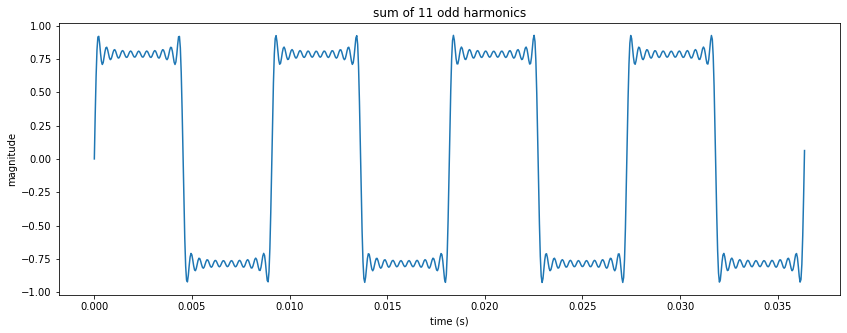

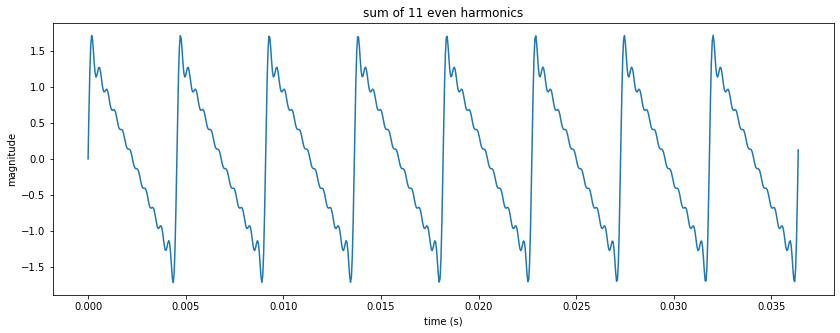

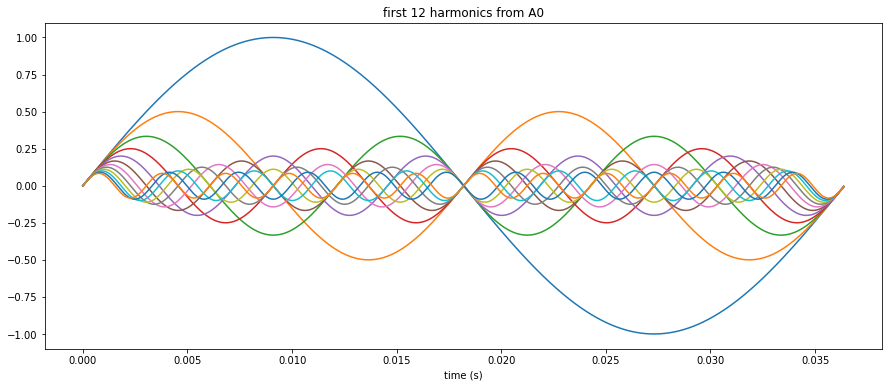

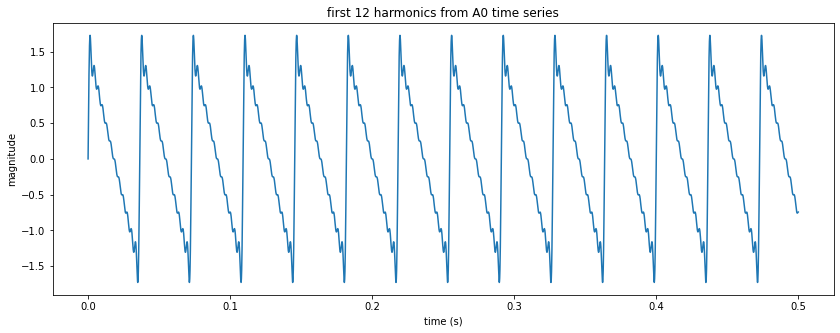

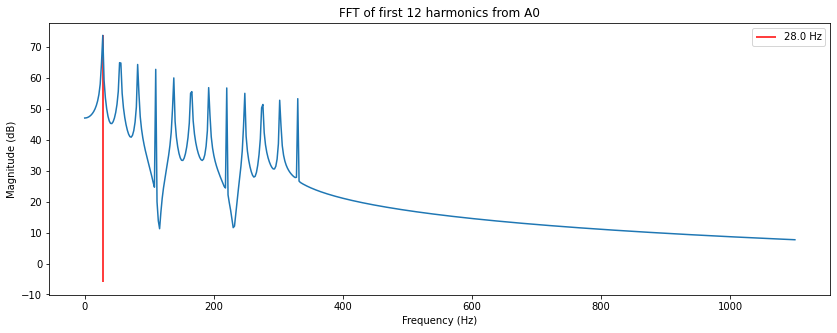

In [10]:
# setup note elements
notes = pitch_dict_create()
intervals = notes['intervals']
note_names = notes['names']
pitch = notes['pitch']

# setup dimensions
T = 1/27.5      # T seconds long
fs = 22050      # Hz
nyq = round(int(fs/2))  # highest freq before aliasing
Ts,N,n = dim_def(T,fs)

# create and plot odd/even harmonic sums
x,x_title = simple_harmonic(N,fs,'A2',pitch,'odd',11)
plot_waveforms(Ts,N,x,x_title)

x,x_title = simple_harmonic(N,fs,'A2',pitch,'even',11)
plot_waveforms(Ts,N,x,x_title)

# plot an overlay of the harmonics
# A0 is at 27.5 Hz, N = 800, therefore:
# 1/(f_A0) = N/fs length of plot matches period of pitch

# time series plot over longer duration
Ts,N,n = dim_def(.5,fs)
x,x_title = simple_harmonic(N,fs,'A0',pitch,'overlay',12)
xt_title = x_title + ' time series'
plot_waveforms(Ts,N,x,xt_title)

# FFT plot
plot_fft(x,x_title,N,fs,20,True)

## Interval Analysis:
### For each of 13 intervals from the root to the octave:
* Give the exact frequency ratio of the interval to the root
* Show the greatest common denominator between the two frequencies
* Show the closest simple ratio to the exact frequency ratio (just vs. equal)
* Show the absolute difference between the two ratios

interval: unison, A4
given note ratio: 1 / 1 = 1.00000 with gcd 440
closest simple ratio: 1 / 1
absolute diff in ratio btwn just and equal temperament: 0.00000


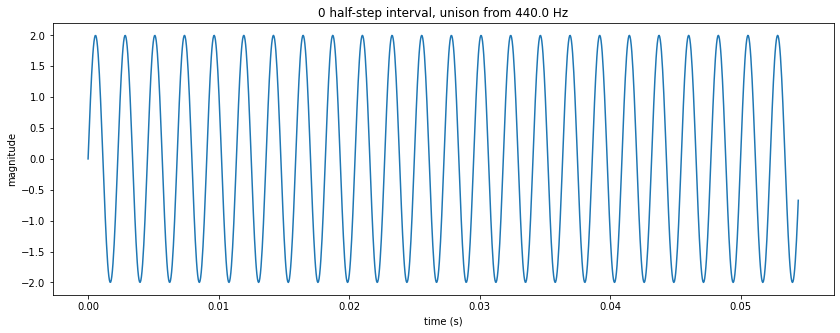

interval: min 2nd, Bb4
given note ratio: 233 / 220 = 1.05909 with gcd 2
closest simple ratio: 11 / 10
absolute diff in ratio btwn just and equal temperament: 0.04091


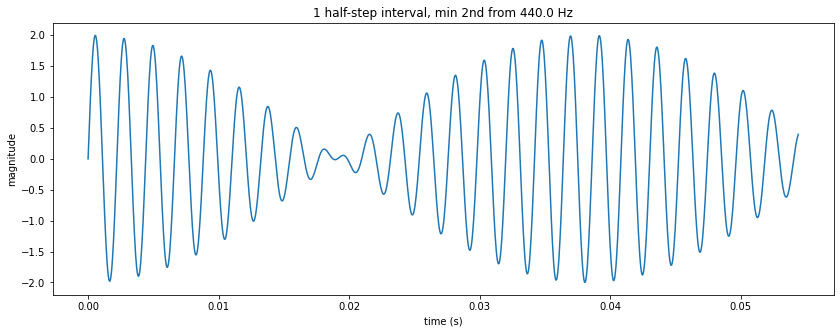

interval: maj 2nd, B4
given note ratio: 247 / 220 = 1.12273 with gcd 2
closest simple ratio: 9 / 8
absolute diff in ratio btwn just and equal temperament: 0.00227


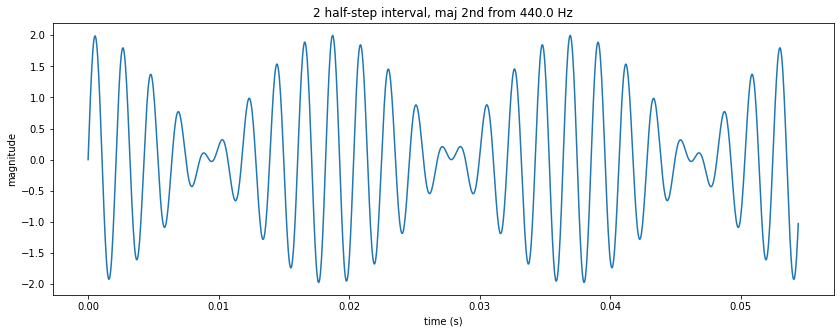

interval: min 3rd, C5
given note ratio: 523 / 440 = 1.18864 with gcd 1
closest simple ratio: 6 / 5
absolute diff in ratio btwn just and equal temperament: 0.01136


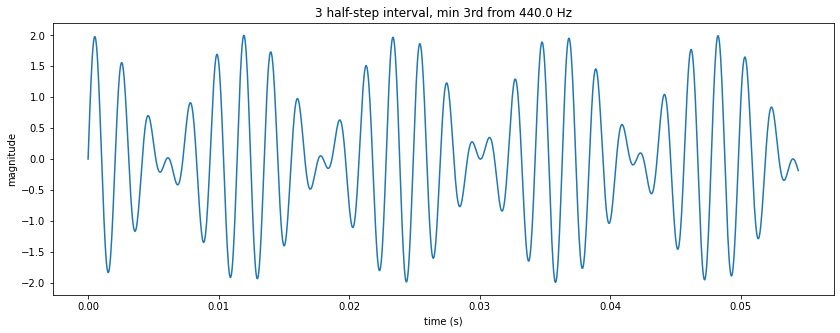

interval: maj 3rd, Db5
given note ratio: 277 / 220 = 1.25909 with gcd 2
closest simple ratio: 5 / 4
absolute diff in ratio btwn just and equal temperament: 0.00909


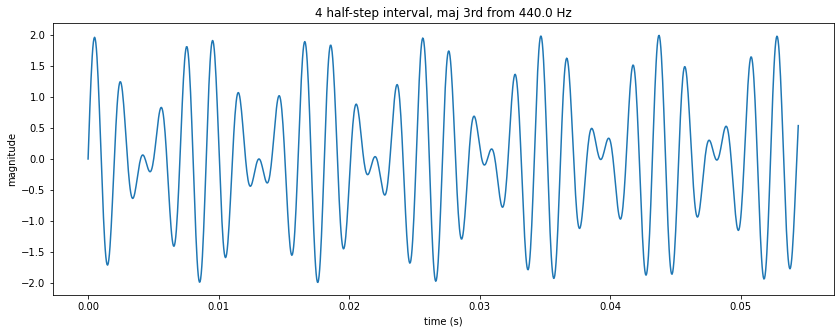

interval: prf 4th, D5
given note ratio: 587 / 440 = 1.33409 with gcd 1
closest simple ratio: 4 / 3
absolute diff in ratio btwn just and equal temperament: 0.00076


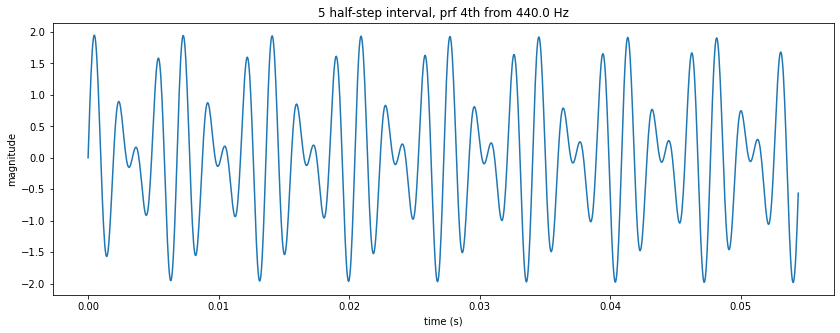

interval: tritone, Eb5
given note ratio: 311 / 220 = 1.41364 with gcd 2
closest simple ratio: 7 / 5
absolute diff in ratio btwn just and equal temperament: 0.01364


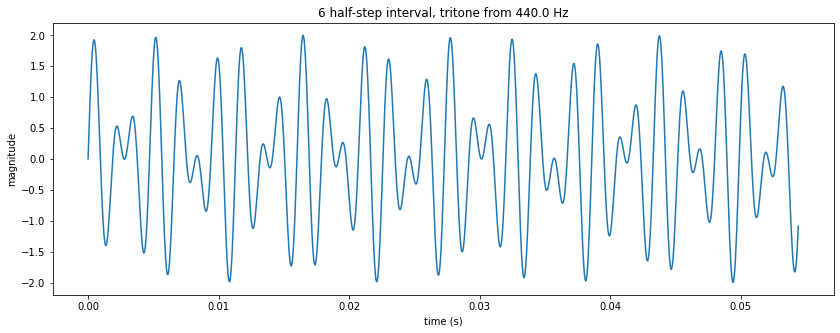

interval: prf 5th, E5
given note ratio: 659 / 440 = 1.49773 with gcd 1
closest simple ratio: 3 / 2
absolute diff in ratio btwn just and equal temperament: 0.00227


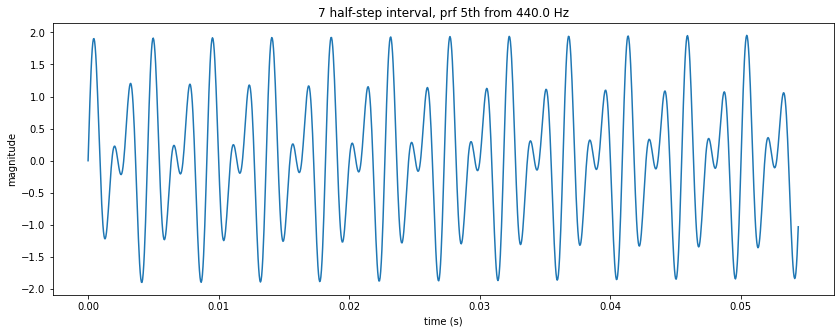

interval: min 6th, F5
given note ratio: 349 / 220 = 1.58636 with gcd 2
closest simple ratio: 8 / 5
absolute diff in ratio btwn just and equal temperament: 0.01364


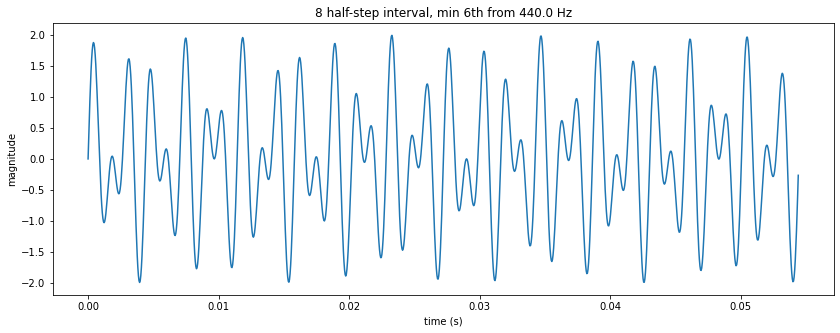

interval: maj 6th, Gb5
given note ratio: 37 / 22 = 1.68182 with gcd 20
closest simple ratio: 5 / 3
absolute diff in ratio btwn just and equal temperament: 0.01515


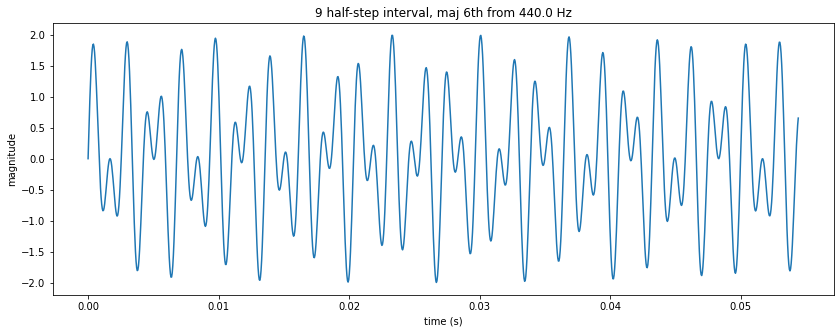

interval: dom 7th, G5
given note ratio: 98 / 55 = 1.78182 with gcd 8
closest simple ratio: 9 / 5
absolute diff in ratio btwn just and equal temperament: 0.01818


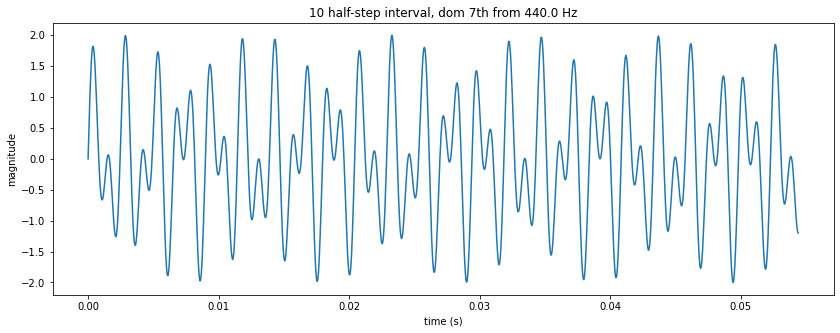

interval: maj 7th, Ab5
given note ratio: 831 / 440 = 1.88864 with gcd 1
closest simple ratio: 11 / 6
absolute diff in ratio btwn just and equal temperament: 0.05530


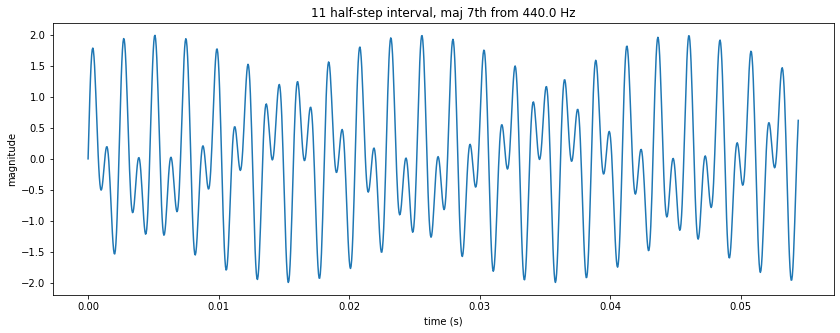

interval: octave, A5
given note ratio: 2 / 1 = 2.00000 with gcd 440
closest simple ratio: 2 / 1
absolute diff in ratio btwn just and equal temperament: 0.00000


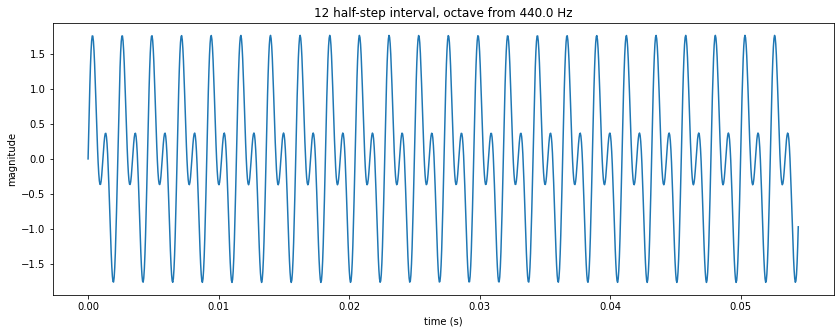

In [11]:
# interval analysis
# use a specific N value:
N = 1200
sCount = 0

# plot 12 intervals
offset = note_names.index('A4')  # starting index at fund
interval_ratio = {}
f0 = pitch['A4']     # fund
for j in range(13):
    
    # get interval stats
    fb = pitch[note_names[offset+j]]
    nume,deno,div,rat = f_to_ratio(fb,f0)
    c_num,c_den,diff = close_to_simple_ratio(nume,deno)
    interval_ratio[intervals[j]] = Fraction(c_num,c_den)
    
    # print interval stats
    print('interval: %s, %s' % (intervals[j],note_names[offset+j]))
    print('given note ratio: %d / %d = %.5f with gcd %d' %(nume,deno,rat,div))
    print('closest simple ratio: %d / %d' %(c_num,c_den))
    print('absolute diff in ratio btwn just and equal temperament: %.5f' % diff)
    
    # plot sum of interval
    x,x_title = two_pure_tones(N,fs,'A4',pitch,j)
    plot_waveforms(Ts,N,x,x_title)
    plt.show()

## Spectral Analysis:
* plot fft of previous waveform, without noise
* include markers at fundamentals and harmonics
* clean up noisy signal, turn into audio file
* notice the difference between placement of odd or even harmonics

### Given two notes in scientific form and a specified number of samples
* Plot interesting waveforms, including harmonics
* experiment with random noise addition

interval between A3 and A3


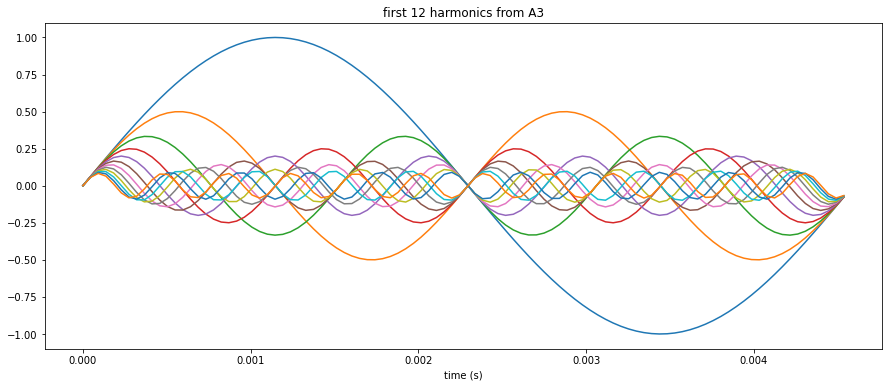

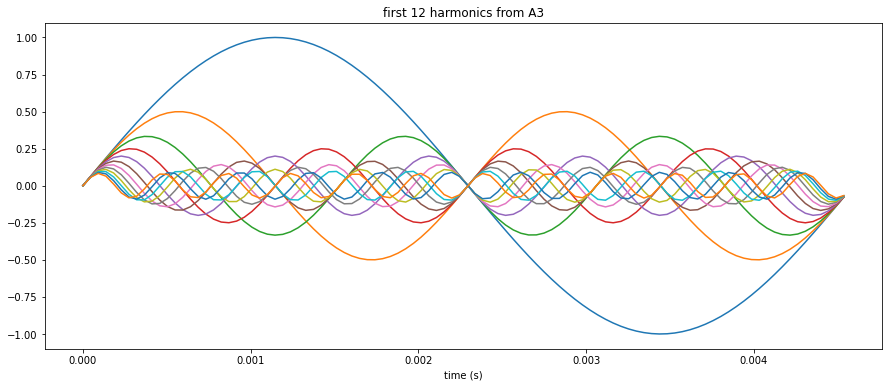

interval between 220.0 Hz and 220.0 Hz


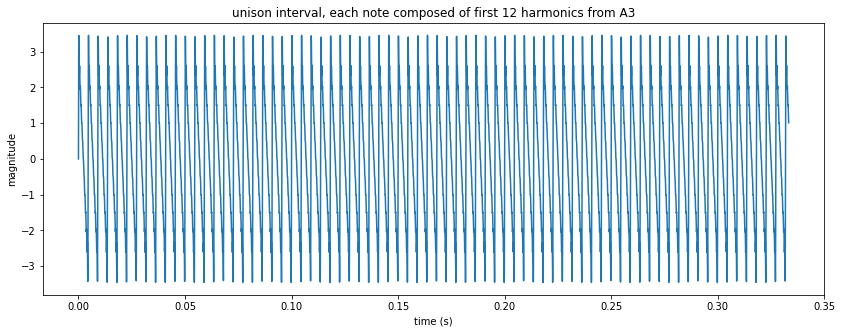

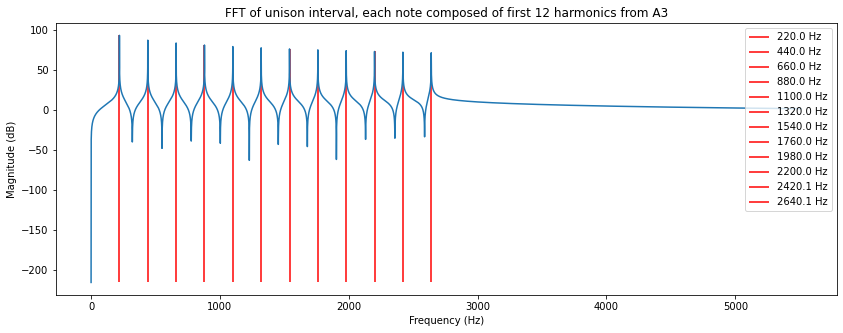

In [12]:
# plot two tones with harmonics summed
N = 2*fs
# choose notes
f0 = 'A3'
fb = 'A3'
print('interval between %s and %s' %(f0,fb))

# get interval name from distance between note names
semi_int = (note_names.index(fb) - note_names.index(f0)) % 12
interval_name = intervals[semi_int]

# combine waveforms and plot
num_harm = 12
harm_type = 'overlay'
x1,x1_title = simple_harmonic(N,fs,f0,pitch,harm_type,num_harm)
x2,_ = simple_harmonic(N,fs,fb,pitch,harm_type,num_harm)
x = x1 + x2
x_title = '%s interval, each note composed of ' %(interval_name) + x1_title
N_short = N//6
x_short = x[:N_short]

plot_waveforms(Ts,N_short,x_short,x_title)

# plot spectral content
# take fft of previous array, x
Y = scipy.fft.fft(x)
Y_mag = 20*np.log10(np.absolute(Y))
y_title = 'FFT of %s' % x_title
f = np.linspace(0, fs, N)
clean_Ymag = Y_mag

# plot fft
plotlen = N//4
plt.figure(figsize=(14, 5))
plt.title(y_title)
plt.plot(f[:plotlen], Y_mag[:plotlen])
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude (dB)')
#plot_fft(Y_mag,y_title,N,fs,4,False)

# find local max/min
mx,mn = findLocalMaximaMinima(N, Y_mag[:N])

# plot vertical lines at peaks
for p in range(len(mx)//2):
    plt.vlines(f[mx[p]],np.amin(Y_mag[:N//4]),Y_mag[mx[p]],colors='r',label='%.1f Hz' %(f[mx[p]]))
plt.legend(loc='upper right')

print('interval between %.1f Hz and %.1f Hz' %(pitch[f0],pitch[fb]))

# create audio of time series
combine = fade(N,x)
name = '%s-%s-%s' %(f0,fb,harm_type)
#write_audio(combine,fs,name,sCount)
ipd.Audio(combine,rate=fs)

In [13]:
# Find closest pitches to harmonics found above
      
P = len(mx)//2
peaks = mx[:P]      # indexes of peaks from previous FFT
f_harms = f[peaks]  # frequencies of peaks in Hz
frq = np.zeros(P)   # new list to store closest equal tempered pitch
harmonics = []      # new list to store names of closest note
freqs=list(pitch.values())    # list of all equal tempered frequencies to search

for m in range(P):
    K = f_harms[m]
    frq[m],index = closest(freqs,K)      # function defined at top
    harmonics.append(note_names[index])
    diff = K - freqs[index]
    cents = 1200*np.log2(K/freqs[index])
    print('measured: %.4f ==> near: %.4f  = %s where harmonic is %.2f Hz from equal = %.2f cents' 
          %(K,frq[m],note_names[index],diff,cents))

print('')
print('the cent differences above are verified as accurate')

measured: 220.0050 ==> near: 220.0000  = A3 where harmonic is 0.00 Hz from equal = 0.04 cents
measured: 440.0100 ==> near: 440.0000  = A4 where harmonic is 0.01 Hz from equal = 0.04 cents
measured: 660.0150 ==> near: 659.2551  = E5 where harmonic is 0.76 Hz from equal = 1.99 cents
measured: 880.0200 ==> near: 880.0000  = A5 where harmonic is 0.02 Hz from equal = 0.04 cents
measured: 1100.0249 ==> near: 1108.7305  = Db6 where harmonic is -8.71 Hz from equal = -13.65 cents
measured: 1320.0299 ==> near: 1318.5102  = E6 where harmonic is 1.52 Hz from equal = 1.99 cents
measured: 1540.0349 ==> near: 1567.9817  = G6 where harmonic is -27.95 Hz from equal = -31.13 cents
measured: 1760.0399 ==> near: 1760.0000  = A6 where harmonic is 0.04 Hz from equal = 0.04 cents
measured: 1980.0449 ==> near: 1975.5332  = B6 where harmonic is 4.51 Hz from equal = 3.95 cents
measured: 2200.0499 ==> near: 2217.4610  = Db7 where harmonic is -17.41 Hz from equal = -13.65 cents
measured: 2420.0549 ==> near: 2489.

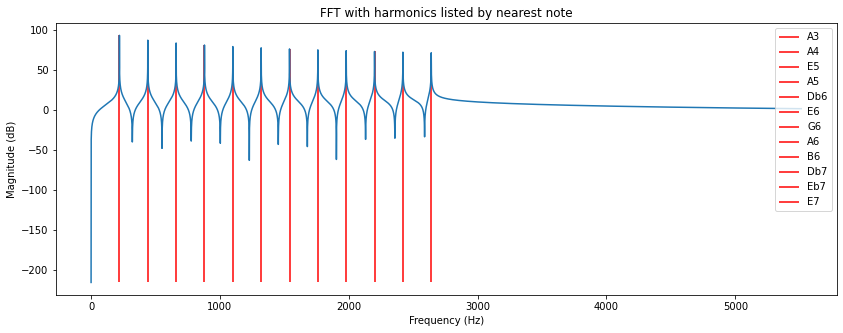

In [14]:
# plot notes closest to harmonics found on fft

# plot fft
plotlen = N//4
plt.figure(figsize=(14, 5))
plt.title('FFT with harmonics listed by nearest note')
plt.plot(f[:plotlen], Y_mag[:plotlen])
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude (dB)')

# plot vertical lines at peaks
for p in range(len(mx)//2):
    plt.vlines(f[mx[p]],np.amin(Y_mag[:N//4]),Y_mag[mx[p]],colors='r',label='%s' %(harmonics[p]))
plt.legend(loc='upper right')

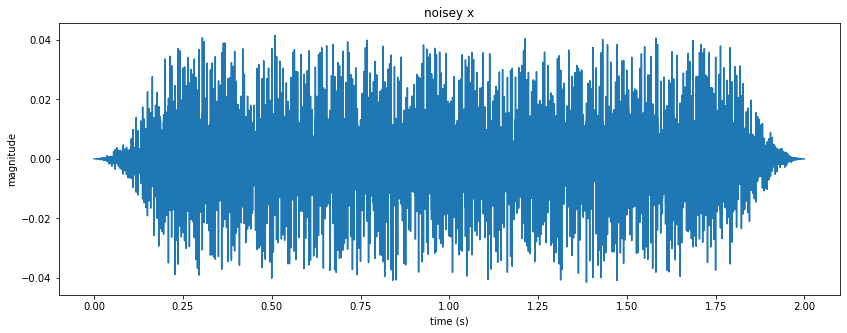

In [15]:
# add some weird noise
# take derivative, normalize, combine with random[0,1]
t = np.linspace(0,Ts*N,N)
dx = np.gradient(x, t)
norm = np.linalg.norm(dx)
norm_dx = dx/norm
rando = np.random.rand(N)
noise = norm_dx * rando

# combine noise and signal, plot
noisex = x * noise
plot_waveforms(Ts,N,noisex,'noisey x')

# output audio
name = '%s-%s-%s' %(f0,fb,'noisy')
#write_audio(noisex,fs,name,sCount)
ipd.Audio(noisex,rate=fs)

44100


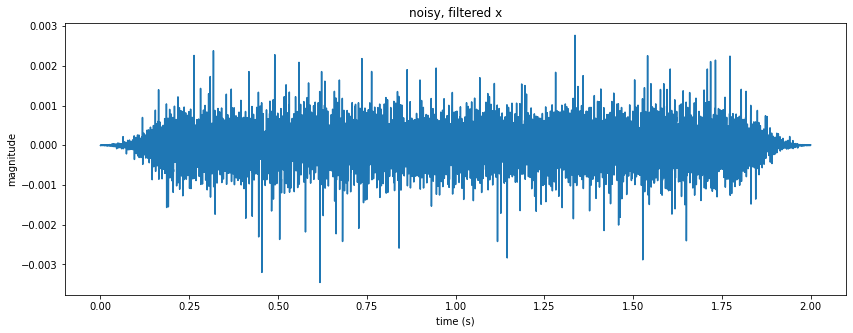

In [16]:
# ideal LPF
#del imp
def impulse_LPF_ideal(fs,N,fc):
    c = fs/N         # coeff
    cutoff = fc      # Hz
    M = int(round(1/c * cutoff)) + 1
    rect = np.zeros(N)
    rect[:M] = 1/M * np.ones(M)
    imp = np.real(scipy.fft.ifft(rect))
    imp = np.roll(imp,N//2)
    imp = imp/np.sum(imp)
    print(len(imp))
    return imp,rect

imp,rect = impulse_LPF_ideal(fs,N,1000)
fnoise = np.convolve(imp,noisex,'same')
#norm = np.linalg.norm(fnoise)
x_filt = fnoise #/norm

#output = fade(N,x_filt)
#write_audio(x_filt,fs,sCount)

# create audio of time series and plot
plot_waveforms(Ts,N,x_filt,'noisy, filtered x')

name = '%s-%s-%s' %(f0,fb,'filt_noisy')
#write_audio(x_filt,fs,name,sCount)
ipd.Audio(x_filt,rate=fs)

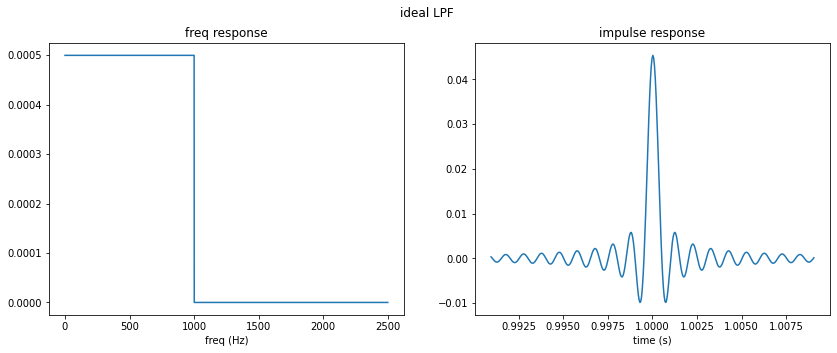

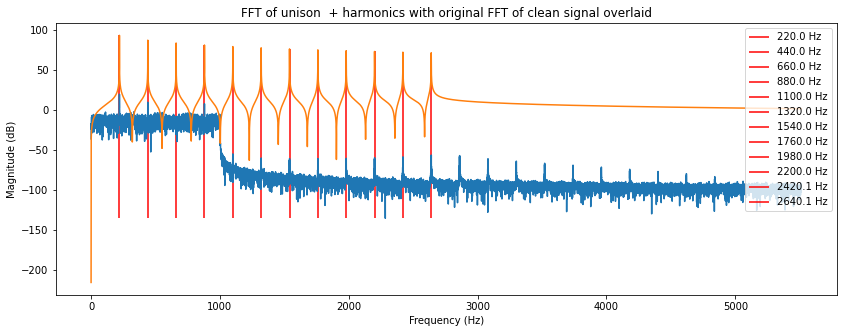

In [17]:
# plot spectral content
# take fft of previous array, x
Y = scipy.fft.fft(x_filt)
Y_mag = 20*np.log10(np.absolute(Y))
y_title = x_title[:7] + ' + harmonics with original FFT of clean signal overlaid'
f = np.linspace(0, fs, N)

# plot freq and impulse responses
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle('ideal LPF')
# plot freq response of LPF
fn = np.linspace(0,fs,N)
ax1.plot(fn[:5000],rect[:5000])
ax1.set_title('freq response')
ax1.set_xlabel('freq (Hz)')
# plot impulse response
start = N//2 - 200
stop = N//2 + 200
ax2.plot(t[start:stop],imp[start:stop])
ax2.set_title('impulse response')
ax2.set_xlabel('time (s)')
plt.show()

# plot fft
#plot_fft(noisex,x_title,N,fs,15)
plotlen = N//4
plt.figure(figsize=(14, 5))
plt.title('FFT of %s' % y_title)
plt.plot(f[:plotlen], Y_mag[:plotlen],f[:plotlen], clean_Ymag[:plotlen])
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude (dB)')

# find local max/min
# use mx from clean signal, above
#mx,mn = findLocalMaximaMinima(N, Y_mag[:N])

# plot vertical lines at peaks
for p in range(len(mx)//2):
    plt.vlines(f[mx[p]],np.amin(Y_mag[:N//4]),clean_Ymag[mx[p]],colors='r',label='%.1f Hz' %(f[mx[p]]))
plt.legend(loc='upper right')

## Musical Scale operations 
* some functions for relating musical notes

In [18]:
# scale stuff
scalenames = getList(scales)
print(scalenames)
print('')

def get_scale(root,name):
    print('list %s %s scale:' % (root,name))
    print(list_scale(root,name,scales,note_names))
    print('')
    
get_scale('A4','lydian')
get_scale('A4','lydaug')

# modes of a major scale
print('modes within a scale:')
get_scale('A4','major')
i_step = 0
for k in range(len(modes)-1):
    i_step = i_step + scales['major'][k]
    next_note = note_interval('A4',i_step,note_names)
    get_scale(next_note,modes[k+1])

# modes of a root note
print('modes from a single root note:')
get_scale('C3','major')
for k in range(len(modes)-1):
    get_scale('C3',modes[k+1])

# note interval
fund = 'A4'
interval = 2
print('given: %s fundamental,' % fund)
print('give the note %d half steps up: ' % interval)
print(note_interval('A4',2,note_names))

['major', 'dimW', 'dimH', 'pentmaj', 'bebopmaj', 'harmmaj', 'lydaug', 'augment', 'blues', 'dorian', 'phrygian', 'lydian', 'mixolydian', 'aeolian', 'locrian']

list A4 lydian scale:
['A4', 'B4', 'Db5', 'Eb5', 'E5', 'Gb5', 'Ab5']

list A4 lydaug scale:
['A4', 'B4', 'Db5', 'Eb5', 'F5', 'Gb5', 'Ab5']

modes within a scale:
list A4 major scale:
['A4', 'B4', 'Db5', 'D5', 'E5', 'Gb5', 'Ab5']

list B4 dorian scale:
['B4', 'Db5', 'D5', 'E5', 'Gb5', 'Ab5', 'A5']

list Db5 phrygian scale:
['Db5', 'D5', 'E5', 'Gb5', 'Ab5', 'A5', 'B5']

list D5 lydian scale:
['D5', 'E5', 'Gb5', 'Ab5', 'A5', 'B5', 'Db6']

list E5 mixolydian scale:
['E5', 'Gb5', 'Ab5', 'A5', 'B5', 'Db6', 'D6']

list Gb5 aeolian scale:
['Gb5', 'Ab5', 'A5', 'B5', 'Db6', 'D6', 'E6']

list Ab5 locrian scale:
['Ab5', 'A5', 'B5', 'Db6', 'D6', 'E6', 'Gb6']

modes from a single root note:
list C3 major scale:
['C3', 'D3', 'E3', 'F3', 'G3', 'A3', 'B3']

list C3 dorian scale:
['C3', 'D3', 'Eb3', 'F3', 'G3', 'A3', 'Bb3']

list C3 phrygian scale

In [19]:
# test audio generation
T = 2
N = T*fs

f0 = 'A2'
interval = 7
fb = note_interval(f0,interval,note_names)
x,x_title = two_pure_tones(N,fs,'A2',pitch,interval)
x = fade(N,x)
name = '%s-%s-%s' %(f0,fb,'noisy')
#write_audio(x,fs,name,sCount)
ipd.Audio(x,rate=fs)

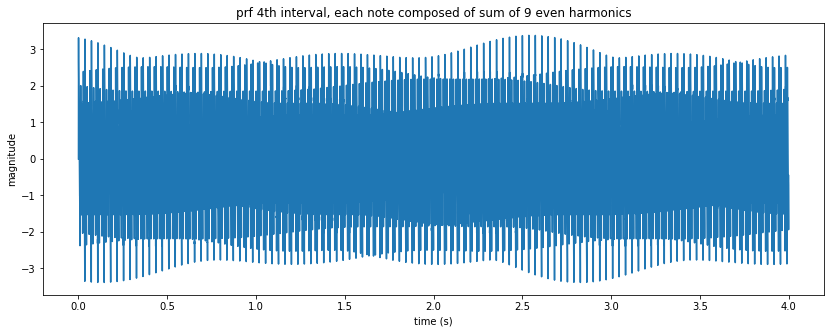

In [20]:
# more audio testing
T = 4
N = T*fs

f0 = 'E1'
fb = 'A1'
# get interval name from distance between note names
semi_int = (note_names.index(fb) - note_names.index(f0)) % 12
interval_name = intervals[semi_int]

num_harm = 9
harm_type = 'even'
x1,x1_title = simple_harmonic(N,fs,f0,pitch,harm_type,num_harm)
x2,_ = simple_harmonic(N,fs,fb,pitch,harm_type,num_harm)
x = x1 + x2
x_title = '%s interval, each note composed of ' %(interval_name) + x1_title
plot_waveforms(Ts,N,x,x_title)
plt.show()

# audio
x = fade(N,x)
ipd.Audio(x,rate=fs)

# Note Analysis on sampled audio

* import monotonic piano sample
* 

samples/Colour_Piano_Down57_a1.wav


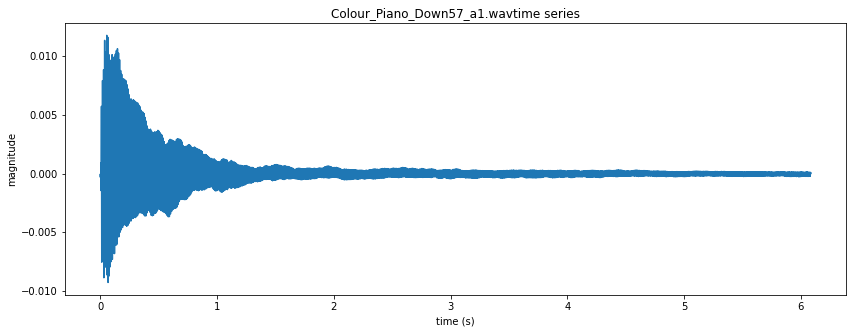

In [22]:
myFiles = glob.glob('samples/*.wav')
filename = myFiles[0]
print(filename)

x, fs = librosa.load(filename)
N = len(x)
n = np.linspace(0,N,N)
Ts = 1/fs
T = N*Ts
t = np.linspace(0,Ts*N,N)

x_title = myFiles[0][8:] + 'time series'
plot_waveforms(Ts,N,x,x_title)
plt.show()

In [23]:
def movAvg(M,array):
    mov = 1/M * np.ones(M)
    smooth = np.convolve(array,mov,'same')
    return smooth

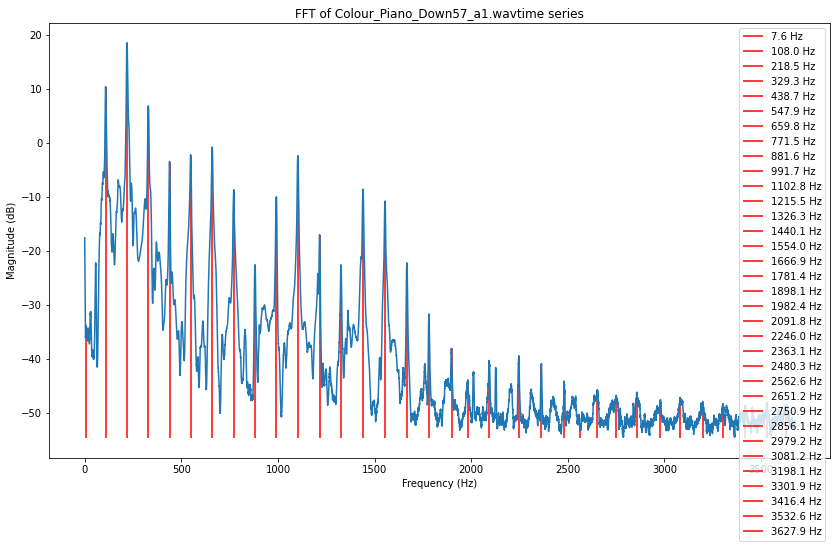

In [46]:
# 
# plot spectral content
# take fft of previous array, x
Yin = scipy.fft.fft(x)
Y_mag = 20*np.log10(np.absolute(Yin))
y_title = 'FFT of %s' % x_title
f = np.linspace(0, fs, N)

Y = movAvg(41,Y_mag)

# plot fft
plotlen = N//6
plt.figure(figsize=(14, 8))
plt.title(y_title)
plt.plot(f[:plotlen], Y[:plotlen])
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude (dB)')
#plot_fft(x,x_title,N,fs,4,False)

# find peaks using peakutils module
mx = peakutils.indexes(Y[:plotlen], thres=0.02/max(Y), min_dist=500)

# plot vertical lines at peaks
for p in range(len(mx)):
    plt.vlines(f[mx[p]],np.amin(Y[:N//4]),Y[mx[p]],colors='r',label='%.1f Hz' %(f[mx[p]]))
plt.legend(loc='upper right')


In [47]:
# Find closest pitches to harmonics found above
      
P = len(mx)//2
peaks = mx[:P]      # indexes of peaks from previous FFT
f_harms = f[peaks]  # frequencies of peaks in Hz
frq = np.zeros(P)   # new list to store closest equal tempered pitch
harmonics = []      # new list to store names of closest note
freqs=list(pitch.values())    # list of all equal tempered frequencies to search

for m in range(P):
    K = f_harms[m]
    frq[m],index = closest(freqs,K)      # function defined at top
    harmonics.append(note_names[index])
    diff = K - freqs[index]
    cents = 1200*np.log2(K/freqs[index])
    print('measured: %.4f ==> near: %.4f  = %s where harmonic is %.2f Hz from equal = %.2f cents' 
          %(K,frq[m],note_names[index],diff,cents))

print('')
print('the cent differences above are verified as accurate')

measured: 7.5589 ==> near: 16.3516  = C0 where harmonic is -8.79 Hz from equal = -1335.83 cents
measured: 107.9602 ==> near: 110.0000  = A2 where harmonic is -2.04 Hz from equal = -32.41 cents
measured: 218.5495 ==> near: 220.0000  = A3 where harmonic is -1.45 Hz from equal = -11.45 cents
measured: 329.3031 ==> near: 329.6276  = E4 where harmonic is -0.32 Hz from equal = -1.70 cents
measured: 438.7422 ==> near: 440.0000  = A4 where harmonic is -1.26 Hz from equal = -4.96 cents
measured: 547.8526 ==> near: 554.3653  = Db5 where harmonic is -6.51 Hz from equal = -20.46 cents
measured: 659.7565 ==> near: 659.2551  = E5 where harmonic is 0.50 Hz from equal = 1.32 cents
measured: 771.4961 ==> near: 783.9909  = G5 where harmonic is -12.49 Hz from equal = -27.81 cents
measured: 881.5925 ==> near: 880.0000  = A5 where harmonic is 1.59 Hz from equal = 3.13 cents
measured: 991.6888 ==> near: 987.7666  = B5 where harmonic is 3.92 Hz from equal = 6.86 cents
measured: 1102.7711 ==> near: 1108.7305 

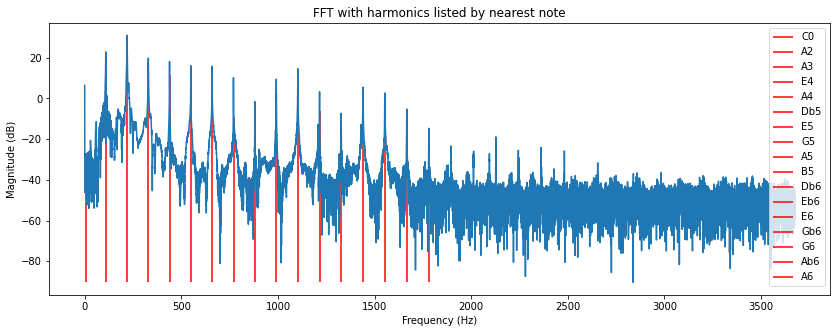

In [51]:
# plot notes closest to harmonics found on fft

# plot fft
plotlen = N//6
plt.figure(figsize=(14, 5))
plt.title('FFT with harmonics listed by nearest note')
plt.plot(f[:plotlen], Y_mag[:plotlen])
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude (dB)')

# plot vertical lines at peaks
for p in range(len(mx)//2):
    plt.vlines(f[mx[p]],np.amin(Y_mag[:N//4]),Y_mag[mx[p]],colors='r',label='%s' %(harmonics[p]))
plt.legend(loc='upper right')